<a href="https://colab.research.google.com/github/manmeet3/Masters_Project/blob/master/wip_colabs/tumor_anomaly/ganomaly-kaggle-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.groundai.com/project/ganomaly-semi-supervised-anomaly-detection-via-adversarial-training/1

https://github.com/chychen/tf2-ganomaly

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/

/content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection


In [ ]:
# %cd ganomaly_tf2
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/metrics.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/model.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/train.py

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
import os
import time
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ganomaly_tf2.model import GANomaly
from absl import logging
logging.set_verbosity(logging.INFO)
logging.set_stderrthreshold(logging.INFO)

from typing import Any, Callable, Optional, Tuple
from PIL import Image
from sklearn.model_selection import train_test_split

2.4.1


In [ ]:
def batch_resize(imgs, size: tuple):
    img_out = np.empty((imgs.shape[0],) + size)
    for i in range(imgs.shape[0]):
        img_out[i] = cv2.resize(imgs[i], size, interpolation=cv2.INTER_CUBIC)
    return img_out

In [ ]:
class Option:
    def __init__(self):
        self.anomaly = 1 # the anomaly digit
        self.shuffle_buffer_size = 10000
        self.batch_size = 8
        self.isize = 256 # input size
        self.ckpt_dir = "ckpt"
        self.nz = 100 # latent dims
        self.nc = 1 # input channels
        self.ndf = 64 # number of discriminator's filters
        self.ngf = 64 # number of generator's filters
        self.extralayers = 0
        self.niter = 15 # number of training epochs
        self.lr = 2e-4 
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5
        self.encdims = None
            
opt = Option()

In [ ]:
data_train, data_test = tf.keras.datasets.mnist.load_data()
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def read_data(path, normal=True):
    data: Any = []
    labels = []
    
    for file_path in glob.glob(path):
        with open (file_path, 'rb') as f:
            # image needs to be a PIL image
            img = Image.open(f).convert('L')
            # image size
            # width, height = img.size
            # mode = img.mode
            # print(f"w: {width} h: {height} mode: {mode}")
            # Resize all images 176, 256, 3 -> 256, 256, 0
            dsize = (256, 256)
            resized = img.resize(dsize)
            # After resize
            # width, height = resized.size
            # mode = resized.mode
            # print(f"RESIZED: w: {width} h: {height} mode: {mode}")
            data.append(resized)
            labels.append(1 if normal else 0) 
            
    data = np.vstack(data).reshape(-1, 256, 256)
    data = data.transpose((0, 1, 2))  # convert to HWC
    return (data, labels)

In [ ]:
train_image_number = 140 # Image slice from MRI scans to use for training data
#root_dir = '/content/drive/MyDrive/Masters_Project/Datasets/OASIS3/'
root = '/content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/'
normal_folder = 'no/'
tumor_folder = 'yes/'

normal_jpg_folder = os.path.join(root, normal_folder)
tumor_jpg_folder = os.path.join(root, tumor_folder)
    
print("="*5 + " Loading Data " + "="*5)
print(f"tumor_jpg_folder: {tumor_jpg_folder}")
print(f"normal_jpg_folder: {normal_jpg_folder}")

non_ad_data: Any = []
non_ad_targets = []

ad_data: Any = []
ad_targets = []

# Read data and label into a numpy array
non_ad_data, non_ad_targets = read_data(normal_jpg_folder+'**.jpg', normal=True)
ad_data, ad_targets = read_data(tumor_jpg_folder+'**.jpg', normal=False)

# shuffle the datasets and bucket them as test and train
# (non_ad_data, non_ad_targets) = shuffle_associated_arrays(non_ad_data, non_ad_targets)
# (ad_data, ad_targets) = shuffle_associated_arrays(ad_data, ad_targets)

all_data = np.concatenate((non_ad_data, ad_data), axis=0)
all_targets = non_ad_targets + ad_targets

x_train, x_test, y_train, y_test =\
  train_test_split(all_data, all_targets, test_size=0.1, random_state=42)

===== Loading Data =====
tumor_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/yes/
normal_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/no/


In [ ]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

y_train = np.array(y_train, dtype=np.intc)
y_test = np.array(y_test, dtype=np.intc)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(153, 256, 256)
(18, 256, 256)


In [ ]:
x_train = batch_resize(x_train, (256, 256))[..., None]
x_test = batch_resize(x_test, (256, 256))[..., None]
# normalization
mean = x_train.mean()
stddev = x_train.std()
x_train = (x_train-mean)/stddev
x_test = (x_test-mean)/stddev
print(x_train.shape, x_train.shape)
# define abnoraml data and normal
# training data only contains normal
x_train = x_train[y_train!=opt.anomaly]
y_train = y_train[y_train!=opt.anomaly]
y_test = (y_test==opt.anomaly).astype(np.float32)
# tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = train_dataset.shuffle(opt.shuffle_buffer_size).batch(opt.batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(opt.batch_size, drop_remainder=False)

(153, 256, 256, 1) (153, 256, 256, 1)


In [ ]:
train_dataset

<BatchDataset shapes: ((8, 256, 256, 1), (8,)), types: (tf.float64, tf.int32)>

In [ ]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float64, tf.float32)>

In [ ]:
ganomaly = GANomaly(opt, train_dataset, valid_dataset=None, test_dataset=test_dataset)

In [19]:
ganomaly.fit(opt.niter)

re-init D, cost: 2.5040 secs
re-init D, cost: 0.1315 secs
epoch: 0, G_losses: 21.5230, D_losses: 7.4331, samples/sec: 25.7035
Best_state: 0.6542866492146597
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.6543   average_precision: 0.0315 ***


epoch: 1, G_losses: 16.5924, D_losses: 7.6246, samples/sec: 28.0207
Best_state: 0.7508180628272251
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.7508   average_precision: 0.0236 ***


epoch: 2, G_losses: 15.4764, D_losses: 7.6246, samples/sec: 28.0070
Best_state: 0.7508180628272251
	 Testing:   roc_auc: 0.6883   average_precision: 0.0225


epoch: 3, G_losses: 15.0281, D_losses: 7.6246, samples/sec: 27.8686
Best_state: 0.9641688481675392
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.9642   average_precision: 0.2823 ***


epoch: 4, G_losses: 14.7033, D_losses: 7.6246, samples/sec: 27.9500
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.7745   average_precision: 0.0389


epoch: 5, G_losses: 14.4275, D_losses: 7.6246, samples/sec: 27.7940
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.7870   average_precision: 0.0826


epoch: 6, G_losses: 14.1367, D_losses: 7.6246, samples/sec: 27.6965
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.4121   average_precision: 0.0097


epoch: 7, G_losses: 100929512.0000, D_losses: 7.6246, samples/sec: 27.8009
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.0242   average_precision: 0.0059


epoch: 8, G_losses: 6315.4858, D_losses: 7.6246, samples/sec: 27.7965
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.0584   average_precision: 0.0060


epoch: 9, G_losses: 1179.6598, D_losses: 7.6246, samples/sec: 27.6906
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.5579   average_precision: 0.0132


epoch: 10, G_losses: 416.9918, D_losses: 7.6246, samples/sec: 27.6606
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.7523   average_precision: 0.0232


epoch: 11, G_losses: 300.1630, D_losses: 7.6246, samples/sec: 27.6470
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.8058   average_precision: 0.0303


epoch: 12, G_losses: 251.8324, D_losses: 7.6246, samples/sec: 27.7031
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.8740   average_precision: 0.0435


epoch: 13, G_losses: 214.6618, D_losses: 7.6246, samples/sec: 27.5888
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.9010   average_precision: 0.0536


epoch: 14, G_losses: 183.7640, D_losses: 7.6246, samples/sec: 27.5882
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.9308   average_precision: 0.0731


epoch: 15, G_losses: 159.0113, D_losses: 7.6246, samples/sec: 27.4805
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.9259   average_precision: 0.0707


epoch: 16, G_losses: 139.1785, D_losses: 7.6246, samples/sec: 27.4911
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.9422   average_precision: 0.0881


epoch: 17, G_losses: 123.2948, D_losses: 7.6246, samples/sec: 27.5409
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.9506   average_precision: 0.1013


epoch: 18, G_losses: 110.8896, D_losses: 7.6246, samples/sec: 27.4525
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.9586   average_precision: 0.1206


epoch: 19, G_losses: 100.5648, D_losses: 7.6246, samples/sec: 27.5216
Best_state: 0.9641688481675392
	 Testing:   roc_auc: 0.9514   average_precision: 0.1095


epoch: 20, G_losses: 92.6299, D_losses: 7.6246, samples/sec: 27.5753
Best_state: 0.9664594240837696
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.9665   average_precision: 0.1518 ***


epoch: 21, G_losses: 85.5923, D_losses: 7.6246, samples/sec: 27.8527
Best_state: 0.9698952879581152
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.9699   average_precision: 0.1635 ***


epoch: 22, G_losses: 87.4227, D_losses: 7.6246, samples/sec: 27.8473
Best_state: 0.9698952879581152
	 Testing:   roc_auc: 0.9660   average_precision: 0.1492


epoch: 23, G_losses: 73.6976, D_losses: 7.6246, samples/sec: 27.6644
Best_state: 0.9703861256544503
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.9704   average_precision: 0.2003 ***


epoch: 24, G_losses: 76.4590, D_losses: 7.6246, samples/sec: 27.7434
Best_state: 0.9733311518324608
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.9733   average_precision: 0.1978 ***


epoch: 25, G_losses: 63.0835, D_losses: 7.6246, samples/sec: 27.6794
Best_state: 0.9766034031413613
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.9766   average_precision: 0.2053 ***


epoch: 26, G_losses: 3551159.0000, D_losses: 7.6246, samples/sec: 27.6561
Best_state: 0.9766034031413613
	 Testing:   roc_auc: 0.9673   average_precision: 0.1979


epoch: 27, G_losses: 1075.8729, D_losses: 7.6246, samples/sec: 27.5767
Best_state: 0.9766034031413613
	 Testing:   roc_auc: 0.9692   average_precision: 0.2116


epoch: 28, G_losses: 486.3383, D_losses: 7.6246, samples/sec: 27.4125
Best_state: 0.9766034031413613
	 Testing:   roc_auc: 0.9719   average_precision: 0.2035


epoch: 29, G_losses: 300.5236, D_losses: 7.6246, samples/sec: 27.4427
Best_state: 0.9766034031413613
	 Testing:   roc_auc: 0.9741   average_precision: 0.2064


epoch: 30, G_losses: 200.7590, D_losses: 7.6246, samples/sec: 27.4501
Best_state: 0.9770942408376964
Saving best state


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_gen/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


INFO:tensorflow:Assets written to: ckpt/_best_disc/assets


*** 	 Testing:   roc_auc: 0.9771   average_precision: 0.2054 ***


epoch: 31, G_losses: 144.2662, D_losses: 7.6246, samples/sec: 27.6858
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9751   average_precision: 0.1878


epoch: 32, G_losses: 115.1969, D_losses: 7.6246, samples/sec: 27.5483
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9576   average_precision: 0.1286


epoch: 33, G_losses: 105.4764, D_losses: 7.6246, samples/sec: 27.6841
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9314   average_precision: 0.1052


epoch: 34, G_losses: 79545.0000, D_losses: 7.6246, samples/sec: 27.5310
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.8523   average_precision: 0.0432


epoch: 35, G_losses: 151.7235, D_losses: 7.6246, samples/sec: 27.5093
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.8747   average_precision: 0.0646


epoch: 36, G_losses: 100.3114, D_losses: 7.6246, samples/sec: 27.6120
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.8441   average_precision: 0.0366


epoch: 37, G_losses: 84.1791, D_losses: 7.6246, samples/sec: 27.4352
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.8645   average_precision: 0.0440


epoch: 38, G_losses: 78.1460, D_losses: 7.6246, samples/sec: 27.3698
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.8830   average_precision: 0.0494


epoch: 39, G_losses: 75.5333, D_losses: 7.6246, samples/sec: 27.6595
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9094   average_precision: 0.0831


epoch: 40, G_losses: 74.2543, D_losses: 7.6246, samples/sec: 27.6236
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.8110   average_precision: 0.0357


epoch: 41, G_losses: 76.1634, D_losses: 7.6246, samples/sec: 27.4246
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.4997   average_precision: 0.0110


epoch: 42, G_losses: 80.5546, D_losses: 7.6246, samples/sec: 27.5300
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9743   average_precision: 0.2099


epoch: 43, G_losses: 79.0764, D_losses: 7.6246, samples/sec: 27.4826
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.7811   average_precision: 0.0558


epoch: 44, G_losses: 76.9991, D_losses: 7.6246, samples/sec: 27.4295
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.7269   average_precision: 0.0246


epoch: 45, G_losses: 74.2099, D_losses: 7.6246, samples/sec: 27.4453
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9570   average_precision: 0.1694


epoch: 46, G_losses: 62.8406, D_losses: 7.6246, samples/sec: 27.4983
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.6741   average_precision: 0.0320


epoch: 47, G_losses: 2616876.5000, D_losses: 7.6246, samples/sec: 27.3512
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9368   average_precision: 0.1243


epoch: 48, G_losses: 279.6823, D_losses: 7.6246, samples/sec: 27.4067
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9401   average_precision: 0.0909


epoch: 49, G_losses: 173.1062, D_losses: 7.6246, samples/sec: 27.4887
Best_state: 0.9770942408376964
	 Testing:   roc_auc: 0.9468   average_precision: 0.1129


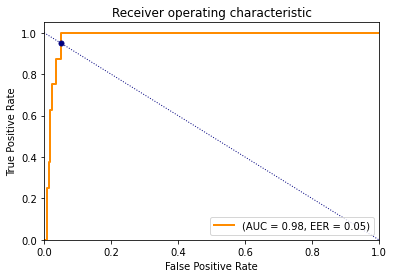

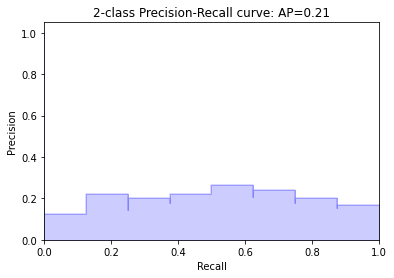

In [20]:
ganomaly.evaluate_best(test_dataset)

# Test

In [ ]:
from PIL import Image as im

In [ ]:
# Load the last saved model
D = tf.keras.models.load_model('ckpt/_best_disc')

In [ ]:
test_x = np.concatenate([x for x, y in test_dataset], axis=0)
test_y = np.concatenate([y for x, y in test_dataset], axis=0)

Saving to: ./output/


INFO:tensorflow:Assets written to: ./output/gen/assets


INFO:tensorflow:Assets written to: ./output/gen/assets


INFO:tensorflow:Assets written to: ./output/disc/assets


INFO:tensorflow:Assets written to: ./output/disc/assets


In [22]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = np.reshape(test_x[19],(256,256)) # 3, 12, 18
plt.imshow(img)
plt.show()

In [ ]:
test_y

(256, 256, 1)

In [ ]:
D.predict(test_dataset)